In [14]:
!pip install scikit-learn

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   --- ------------------------------------ 1.0/10.7 MB 6.3 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/10.7 MB 3.7 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/10.7 MB 3.8 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/10.7 MB 3.6 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/10.7 MB 3.4 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/10.7 MB 3.4 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/10.7 MB 3.3 MB/s eta 0:00:02
   -------------------- ------------------- 5.5/10.7 MB 3.3 MB/s eta 0:00:02
   ---------------------- ----------------- 6.0/10.7 MB 3.2 MB/s eta 0:00:02
   ------------------------ --------------- 6.6/10.7 MB 3.2 MB/s eta 0:00:02
   --------------------------- ------------ 7.3/10.7 MB 3.2 MB/s eta 0:00:02
   ---------------------------- ----------- 7.6/10.7 MB 3.0 MB/s eta 0:00:02
   ---


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [5]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')



In [6]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
                                                               #RFM table


# Recency is directly present in the dataset (days since last purchase). So we'll use the same column as it is.
# Frequency: sum of different purchase counts.

df['Frequency'] = (df['NumDealsPurchases'] 
                   + df['NumWebPurchases'] 
                   + df['NumCatalogPurchases'] 
                   + df['NumStorePurchases'])

In [8]:
# Monetary: sum of money spent on all products

df['Monetary'] = (df['MntWines'] 
                  + df['MntFruits'] 
                  + df['MntMeatProducts'] 
                  + df['MntFishProducts'] 
                  + df['MntSweetProducts'] 
                  + df['MntGoldProds'])

In [9]:
rfm = df[['ID', 'Recency', 'Frequency', 'Monetary']].copy()
rfm.rename(columns={'ID': 'customer_id'}, inplace=True)

# Check what it looks like
print(rfm.head())

   customer_id  Recency  Frequency  Monetary
0         5524       58         25      1617
1         2174       38          6        27
2         4141       26         21       776
3         6182       26          8        53
4         5324       94         19       422


In [10]:
rfm.to_csv('rfm_data.csv', index=False)


In [16]:
                                                       #scaling data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

#Now X_scaled is a numpy array where each feature has mean=0, std=1.


In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


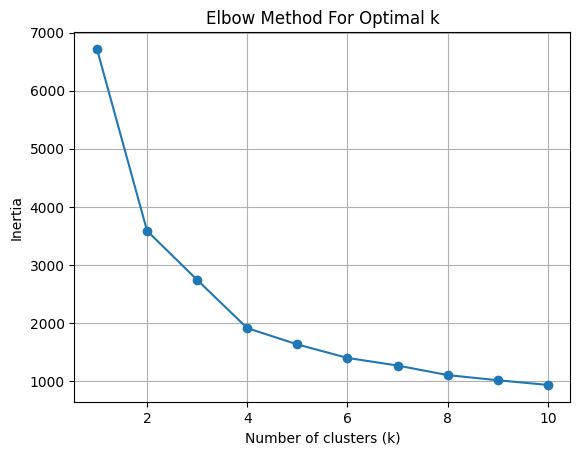

In [18]:
#plotting elbow curve

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [25]:
#silhouette score


for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"For k = {k}, the silhouette score is {score:.4f}")

For k = 2, the silhouette score is 0.4177
For k = 3, the silhouette score is 0.3820
For k = 4, the silhouette score is 0.3774
For k = 5, the silhouette score is 0.3671


In [26]:
# Best choice is k = 2, because it has the highest silhouette score — indicating the cleanest separation of customers into distinct groups.

rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'NumCustomers'}).reset_index()


,Cluster,Recency,Frequency,Monetary,NumCustomers
0,0,26.354244,7.339483,84.662362,542
1,1,26.028754,22.581470,1475.923323,313
2,2,26.866667,19.172222,576.883333,360
3,3,77.078095,8.704762,130.201905,525
4,4,74.872000,21.546000,1146.206000,500


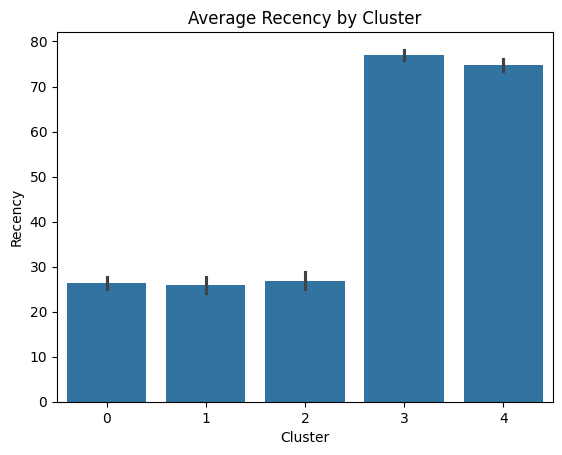

In [27]:
sns.barplot(x='Cluster', y='Recency', data=rfm)
plt.title('Average Recency by Cluster')
plt.show()

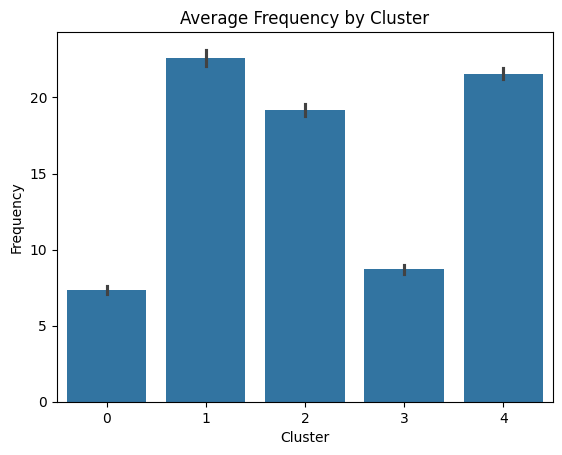

In [28]:
sns.barplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Average Frequency by Cluster')
plt.show()




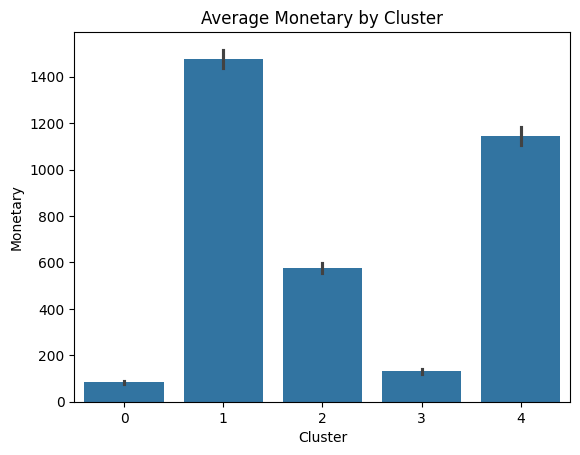

In [29]:
sns.barplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Average Monetary by Cluster')
plt.show()

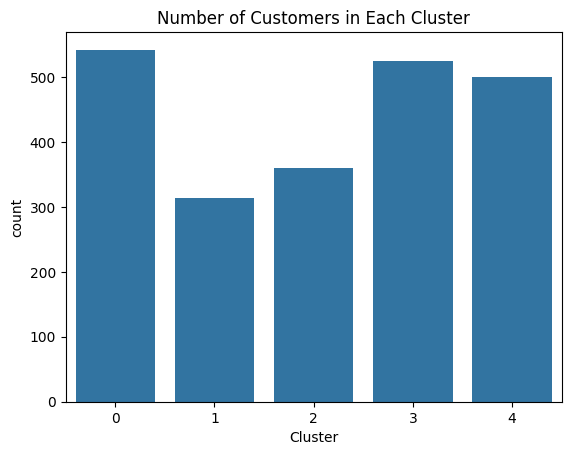

In [30]:
sns.countplot(x='Cluster', data=rfm)
plt.title('Number of Customers in Each Cluster')
plt.show()


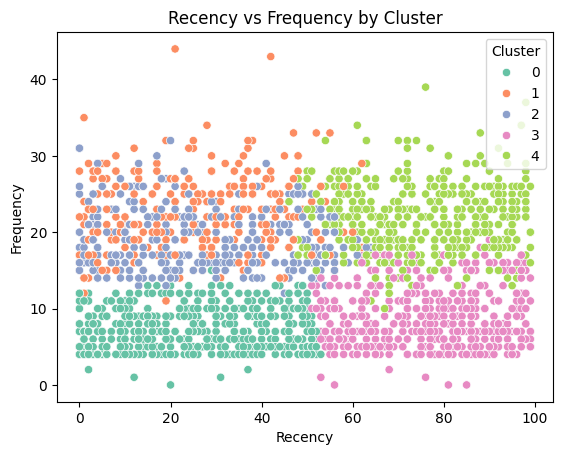

In [31]:
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm, palette='Set2')
plt.title('Recency vs Frequency by Cluster')
plt.show()


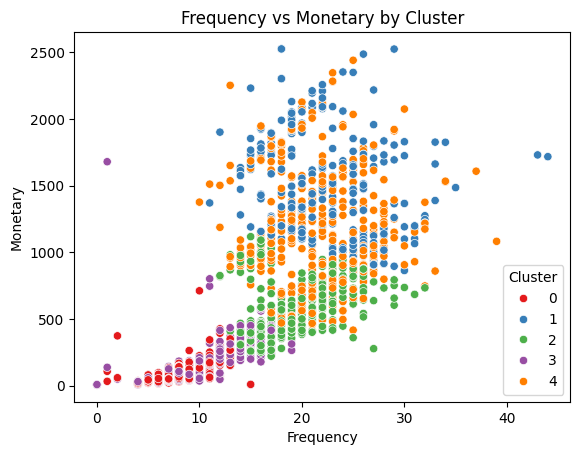

In [32]:
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='Set1')
plt.title('Frequency vs Monetary by Cluster')
plt.show()


In [36]:
rfm.to_csv('customer_segments.csv', index=False, sep=',')

